In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error as msle
from tqdm import tqdm
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# LightGBM key parameters:
"""
Core Parameters:
- n_estimators
- learning_rate


Tree Parameters:
- num_leaves 
- max_depth
- min_child_samples
- min_split_gain 

Subsampling
    'subsample'
"""

In [2]:
data = pd.read_csv('P:/My Documents/Books & Research/Analytics Vidya Blackbelt program/Retail demand prediction/XGBoostandCatBoostnotebooks-191226-113008/final_data.csv')
data.head()

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MANUFACTURER_1,MANUFACTURER_2,MANUFACTURER_3,...,week,quarter,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY,UNITS_BEFORE_52WEEK,price_difference,2_MONTH_BEFORE,1_WEEK_BEFORE,AVERAGE_UNITS_IN_2_MONTH
0,2009-01-14,367,1111009477,1.57,0,0,13,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
1,2009-01-14,367,1111009497,1.39,0,0,20,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
2,2009-01-14,367,1111085319,1.88,0,0,14,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
3,2009-01-14,367,1111085345,1.88,0,0,29,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
4,2009-01-14,367,1111085350,1.98,0,0,35,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0


In [3]:
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)
data = data.drop(columns=['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

week = data.WEEK_END_DATE.unique()


In [4]:
data.columns

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'BASE_PRICE', 'FEATURE', 'DISPLAY',
       'UNITS', 'MANUFACTURER_1', 'MANUFACTURER_2', 'MANUFACTURER_3',
       'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6', 'MANUFACTURER_7',
       'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1', 'CATEGORY_2',
       'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1', 'SUB_CATEGORY_2',
       'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5', 'SUB_CATEGORY_6',
       'SUB_CATEGORY_7', 'PRODUCT_SIZE', 'year', 'month', 'day', 'day_of_year',
       'week', 'quarter', 'U_MANUFACTURER', 'U_CATEGORY', 'U_SUB_CATEGORY',
       'UNITS_BEFORE_52WEEK', 'price_difference', 'AVERAGE_UNITS_IN_2_MONTH'],
      dtype='object')

In [5]:
def validation_df(data, week, no_of_months, no_of_validation):
    model_set = []
    set_n = 1
    for w in range(len(week) - 1, 0, -1):
        x_data = {}
        x_data['train_start'] = week[w - 3 - 4 * no_of_months]
        x_data['train_end'] = week[w - 4]
        x_data['validate_week'] = week[w - 2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set' + str(set_n)
        set_n += 1
        model_set.append(x_data)
        if (len(model_set) == no_of_validation):
            break

    datapoints = []
    for s in model_set:
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape'] = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df

    

In [6]:
# Get evaluation sets
def get_evaluation_sets(df):
    evaluation_set = []
    for row in range(df.shape[0]):
        train_data = data[
            (data.WEEK_END_DATE >= df.loc[row]['train_start']) & 
            (data.WEEK_END_DATE <= df.loc[row]['train_end'])
        ]
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        evaluation_set.append((train_data, validation_data))
    return evaluation_set

validation_df_result = validation_df(data, week, no_of_months=2, no_of_validation=14)
evaluation_set = get_evaluation_sets(validation_df_result)

# RMSLE function
def get_msle(true, predicted):
    # Clipping negative predictions to 0 for RMSLE calculation
    predicted = predicted.clip(min=0)
    return np.sqrt(msle(true, predicted))


Tuning n_estimators:   7%|████▏                                                         | 1/15 [00:03<00:53,  3.81s/it]

n_estimators:  100 | Train RMSLE: 0.6513 | Valid RMSLE: 0.6738


Tuning n_estimators:  13%|████████▎                                                     | 2/15 [00:13<01:37,  7.47s/it]

n_estimators:  200 | Train RMSLE: 0.4983 | Valid RMSLE: 0.5407


Tuning n_estimators:  20%|████████████▍                                                 | 3/15 [00:27<02:05, 10.46s/it]

n_estimators:  300 | Train RMSLE: 0.4338 | Valid RMSLE: 0.4935


Tuning n_estimators:  27%|████████████████▌                                             | 4/15 [00:42<02:14, 12.23s/it]

n_estimators:  400 | Train RMSLE: 0.4058 | Valid RMSLE: 0.4763


Tuning n_estimators:  33%|████████████████████▋                                         | 5/15 [00:54<02:00, 12.07s/it]

n_estimators:  500 | Train RMSLE: 0.3895 | Valid RMSLE: 0.4687


Tuning n_estimators:  40%|████████████████████████▊                                     | 6/15 [01:08<01:53, 12.61s/it]

n_estimators:  600 | Train RMSLE: 0.3792 | Valid RMSLE: 0.4652


Tuning n_estimators:  47%|████████████████████████████▉                                 | 7/15 [01:25<01:53, 14.23s/it]

n_estimators:  700 | Train RMSLE: 0.3720 | Valid RMSLE: 0.4637


Tuning n_estimators:  53%|█████████████████████████████████                             | 8/15 [01:43<01:47, 15.42s/it]

n_estimators:  800 | Train RMSLE: 0.3669 | Valid RMSLE: 0.4633


Tuning n_estimators:  60%|█████████████████████████████████████▏                        | 9/15 [02:03<01:41, 16.90s/it]

n_estimators:  900 | Train RMSLE: 0.3629 | Valid RMSLE: 0.4634


Tuning n_estimators:  67%|████████████████████████████████████████▋                    | 10/15 [02:28<01:36, 19.26s/it]

n_estimators: 1000 | Train RMSLE: 0.3594 | Valid RMSLE: 0.4633


Tuning n_estimators:  73%|████████████████████████████████████████████▋                | 11/15 [02:53<01:23, 20.98s/it]

n_estimators: 1100 | Train RMSLE: 0.3564 | Valid RMSLE: 0.4635


Tuning n_estimators:  80%|████████████████████████████████████████████████▊            | 12/15 [03:22<01:10, 23.34s/it]

n_estimators: 1200 | Train RMSLE: 0.3536 | Valid RMSLE: 0.4636


Tuning n_estimators:  87%|████████████████████████████████████████████████████▊        | 13/15 [04:03<00:57, 28.96s/it]

n_estimators: 1300 | Train RMSLE: 0.3510 | Valid RMSLE: 0.4638


Tuning n_estimators:  93%|████████████████████████████████████████████████████████▉    | 14/15 [04:47<00:33, 33.21s/it]

n_estimators: 1400 | Train RMSLE: 0.3486 | Valid RMSLE: 0.4640


Tuning n_estimators: 100%|█████████████████████████████████████████████████████████████| 15/15 [05:20<00:00, 21.34s/it]

n_estimators: 1500 | Train RMSLE: 0.3463 | Valid RMSLE: 0.4642


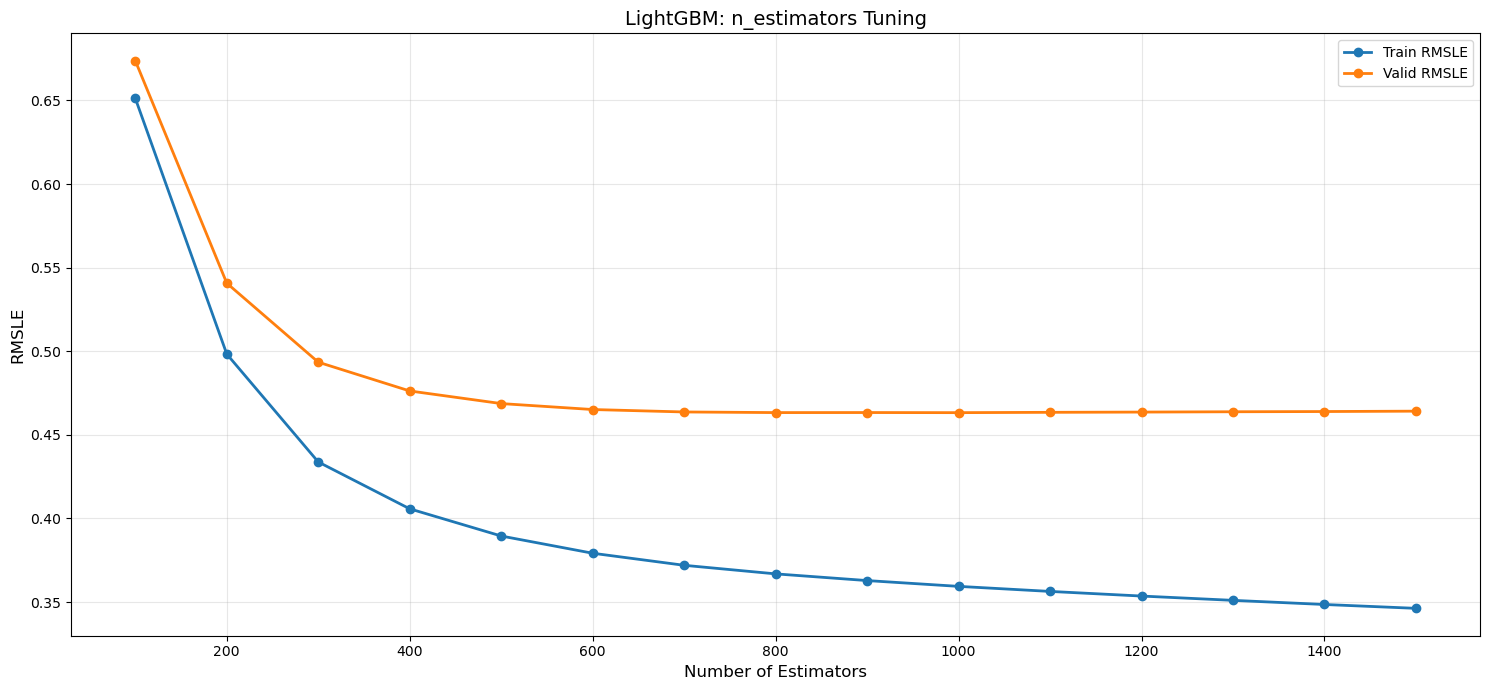

In [7]:
# Tune n_estimators 

def get_n_estimators_lgb(evaluation_set, min_r=100, max_r=1501, step=100):
    results = []
    
    for n_est in tqdm(range(min_r, max_r, step), desc="Tuning n_estimators"):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
             train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']
 
            model = lgb.LGBMRegressor(
                n_estimators=n_est,
                learning_rate=0.01,
                num_leaves=31,
                max_depth=-1,
                min_child_samples=20,
                random_state=0,
                n_jobs=4,
                verbosity=-1
            )

            model.fit(train_data_x, train_data_y)

            train_pred = model.predict(train_data_x)
            valid_pred = model.predict(valid_data_x)

            SCORE_TRAIN.append(get_msle(train_data_y, train_pred))
            SCORE_VALID.append(get_msle(valid_data_y, valid_pred))

        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'n_estimators: {n_est:4d} | Train RMSLE: {mean_score_train:.4f} | Valid RMSLE: {mean_score_valid:.4f}')
        
        x['n_estimators'] = n_est
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame.from_dict(results)

n_estimators_result = get_n_estimators_lgb(evaluation_set, min_r=100, max_r=1501, step=100)

# Plot n_estimators results
plt.figure(figsize=(15, 7))
plt.plot(n_estimators_result['n_estimators'], n_estimators_result['mean_rmsle_train'], 
         label='Train RMSLE', marker='o', linewidth=2)
plt.plot(n_estimators_result['n_estimators'], n_estimators_result['mean_rmsle_valid'], 
         label='Valid RMSLE', marker='o', linewidth=2)
plt.xlabel('Number of Estimators', fontsize=12)
plt.ylabel('RMSLE', fontsize=12)
plt.title('LightGBM: n_estimators Tuning', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Best validation RMSLE is at n_estimators = 800 train RMSLE also continues to plateau at same level

num_leaves:  20 | Train RMSLE: 0.3809 | Valid RMSLE: 0.4623
num_leaves:  30 | Train RMSLE: 0.3678 | Valid RMSLE: 0.4640
num_leaves:  40 | Train RMSLE: 0.3587 | Valid RMSLE: 0.4615
num_leaves:  50 | Train RMSLE: 0.3511 | Valid RMSLE: 0.4625
num_leaves:  60 | Train RMSLE: 0.3449 | Valid RMSLE: 0.4625
num_leaves:  70 | Train RMSLE: 0.3392 | Valid RMSLE: 0.4632
num_leaves:  80 | Train RMSLE: 0.3339 | Valid RMSLE: 0.4629
num_leaves:  90 | Train RMSLE: 0.3290 | Valid RMSLE: 0.4638
num_leaves: 100 | Train RMSLE: 0.3243 | Valid RMSLE: 0.4653
num_leaves: 110 | Train RMSLE: 0.3203 | Valid RMSLE: 0.4654
num_leaves: 120 | Train RMSLE: 0.3160 | Valid RMSLE: 0.4650
num_leaves: 130 | Train RMSLE: 0.3117 | Valid RMSLE: 0.4644
num_leaves: 140 | Train RMSLE: 0.3078 | Valid RMSLE: 0.4658
num_leaves: 150 | Train RMSLE: 0.3040 | Valid RMSLE: 0.4669


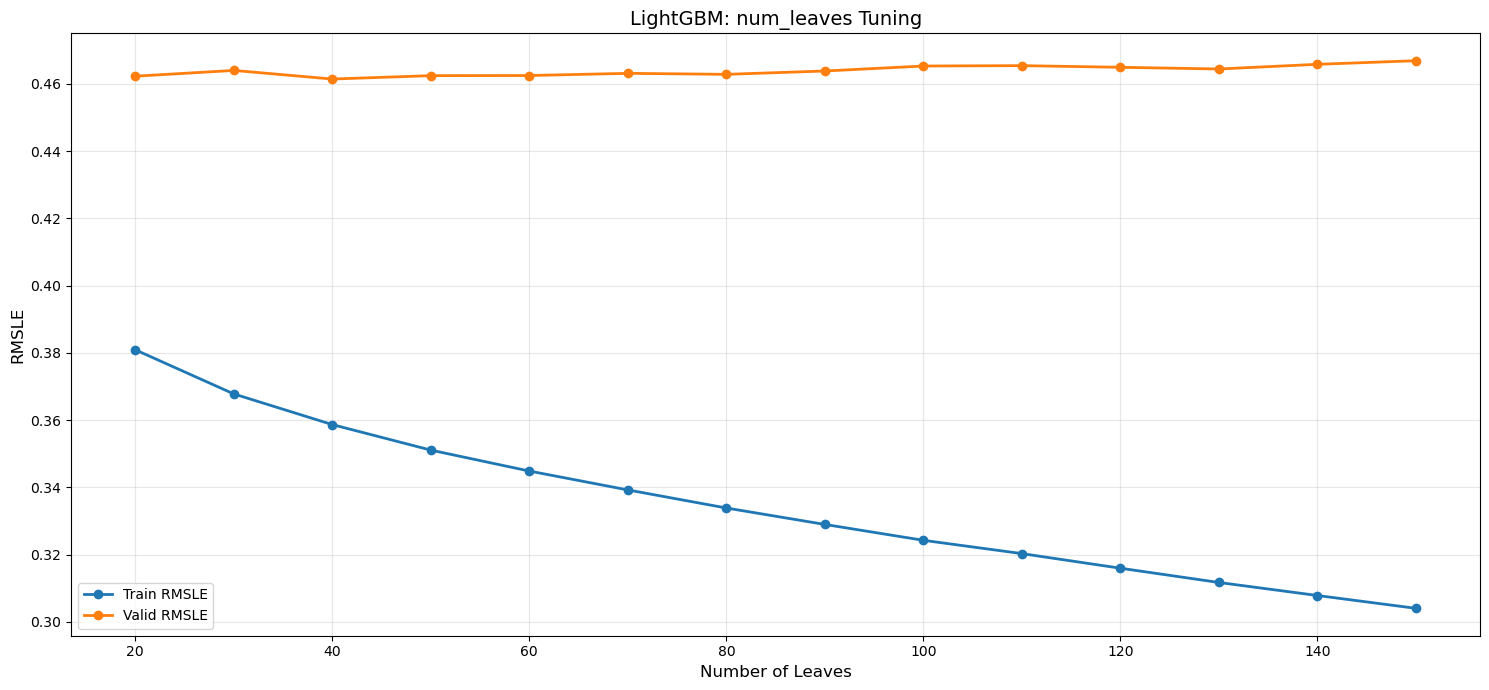

In [8]:
# Tune num_leaves

def get_num_leaves(evaluation_set, optimal_n_estimators=800):
    results = []
    
    for num_leaves in range(20, 151, 10):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
            train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            model = lgb.LGBMRegressor(
                n_estimators=optimal_n_estimators,
                learning_rate=0.01,
                num_leaves=num_leaves,
                max_depth=-1,
                min_child_samples=20,
                random_state=0,
                n_jobs=4,
                verbosity=-1
            )

            model.fit(train_data_x, train_data_y)
  
            train_pred = model.predict(train_data_x)
            valid_pred = model.predict(valid_data_x)
   
            SCORE_TRAIN.append(get_msle(train_data_y, train_pred))
            SCORE_VALID.append(get_msle(valid_data_y, valid_pred))
 
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'num_leaves: {num_leaves:3d} | Train RMSLE: {mean_score_train:.4f} | Valid RMSLE: {mean_score_valid:.4f}')
        
        x['num_leaves'] = num_leaves
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame.from_dict(results)

num_leaves_result = get_num_leaves(evaluation_set, optimal_n_estimators=800)

# Plot num_leaves results
plt.figure(figsize=(15, 7))
plt.plot(num_leaves_result['num_leaves'], num_leaves_result['mean_rmsle_train'], 
         label='Train RMSLE', marker='o', linewidth=2)
plt.plot(num_leaves_result['num_leaves'], num_leaves_result['mean_rmsle_valid'], 
         label='Valid RMSLE', marker='o', linewidth=2)
plt.xlabel('Number of Leaves', fontsize=12)
plt.ylabel('RMSLE', fontsize=12)
plt.title('LightGBM: num_leaves Tuning', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Validation RMSLE seems to be optimal at num_leaves = 80, where train RMSLE is also relatively lower

min_child_samples:   5 | Train RMSLE: 0.3323 | Valid RMSLE: 0.4622
min_child_samples:  10 | Train RMSLE: 0.3336 | Valid RMSLE: 0.4652
min_child_samples:  20 | Train RMSLE: 0.3339 | Valid RMSLE: 0.4629
min_child_samples:  30 | Train RMSLE: 0.3335 | Valid RMSLE: 0.4654
min_child_samples:  40 | Train RMSLE: 0.3326 | Valid RMSLE: 0.4646
min_child_samples:  50 | Train RMSLE: 0.3305 | Valid RMSLE: 0.4624
min_child_samples: 100 | Train RMSLE: 0.3289 | Valid RMSLE: 0.4688


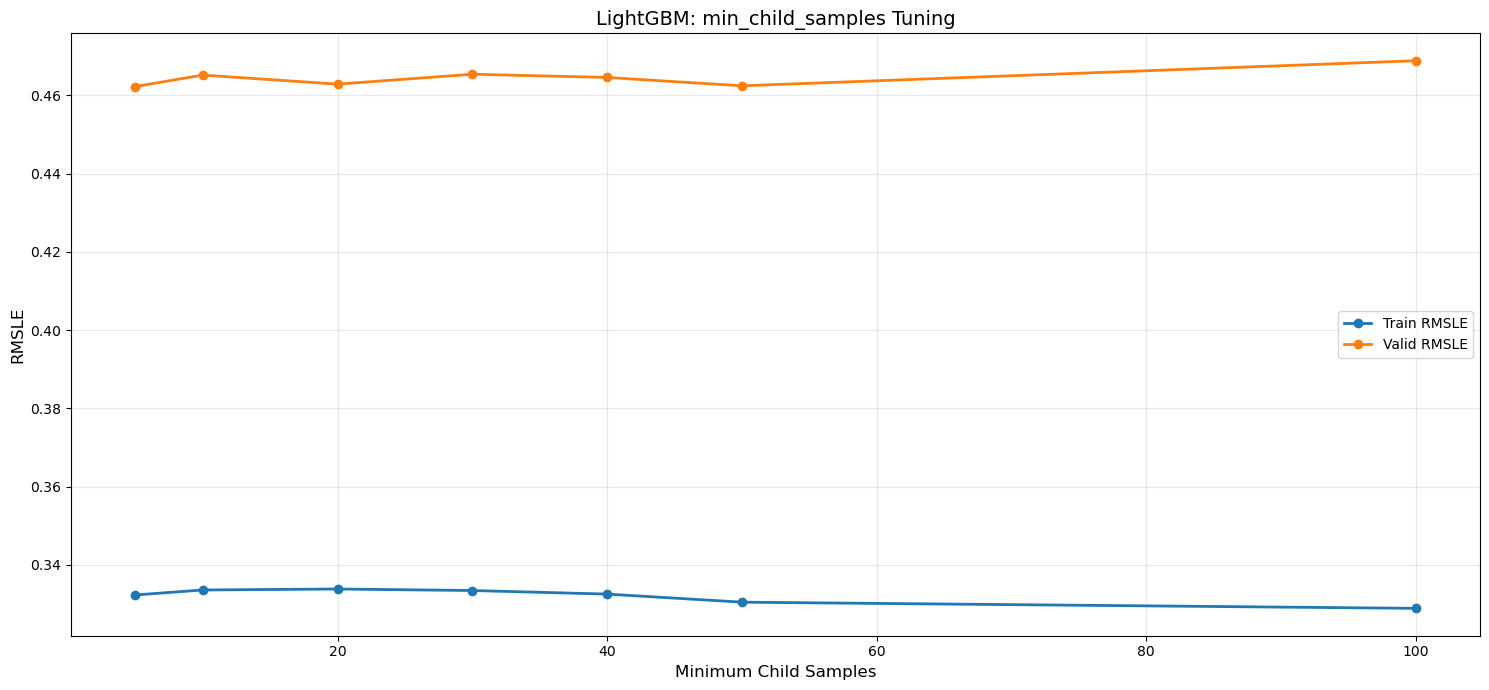

In [9]:
#  Tune min_child_samples

def get_min_child_samples(evaluation_set, optimal_n_estimators=800, optimal_num_leaves=80):
    results = []
    
    for min_samples in [5, 10, 20, 30, 40, 50, 100]:
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
            train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            model = lgb.LGBMRegressor(
                n_estimators=optimal_n_estimators,
                learning_rate=0.01,
                num_leaves=optimal_num_leaves,
                max_depth=-1,
                min_child_samples=min_samples,
                random_state=0,
                n_jobs=4,
                verbosity=-1
            )

            model.fit(train_data_x, train_data_y)
      
            train_pred = model.predict(train_data_x)
            valid_pred = model.predict(valid_data_x)
    
            SCORE_TRAIN.append(get_msle(train_data_y, train_pred))
            SCORE_VALID.append(get_msle(valid_data_y, valid_pred))

        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'min_child_samples: {min_samples:3d} | Train RMSLE: {mean_score_train:.4f} | Valid RMSLE: {mean_score_valid:.4f}')
        
        x['min_child_samples'] = min_samples
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame.from_dict(results)

# min_child_samples tuning
min_child_result = get_min_child_samples(evaluation_set, optimal_n_estimators=800, optimal_num_leaves=80)

# Plot min_child_samples results
plt.figure(figsize=(15, 7))
plt.plot(min_child_result['min_child_samples'], min_child_result['mean_rmsle_train'], 
         label='Train RMSLE', marker='o', linewidth=2)
plt.plot(min_child_result['min_child_samples'], min_child_result['mean_rmsle_valid'], 
         label='Valid RMSLE', marker='o', linewidth=2)
plt.xlabel('Minimum Child Samples', fontsize=12)
plt.ylabel('RMSLE', fontsize=12)
plt.title('LightGBM: min_child_samples Tuning', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

max_depth:  3 | Train RMSLE: 0.4239 | Valid RMSLE: 0.4792
max_depth:  4 | Train RMSLE: 0.3974 | Valid RMSLE: 0.4641
max_depth:  5 | Train RMSLE: 0.3807 | Valid RMSLE: 0.4678
max_depth:  6 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
max_depth:  7 | Train RMSLE: 0.3520 | Valid RMSLE: 0.4657
max_depth:  8 | Train RMSLE: 0.3483 | Valid RMSLE: 0.4660
max_depth:  9 | Train RMSLE: 0.3438 | Valid RMSLE: 0.4684
max_depth: 10 | Train RMSLE: 0.3407 | Valid RMSLE: 0.4648
max_depth: 11 | Train RMSLE: 0.3390 | Valid RMSLE: 0.4638


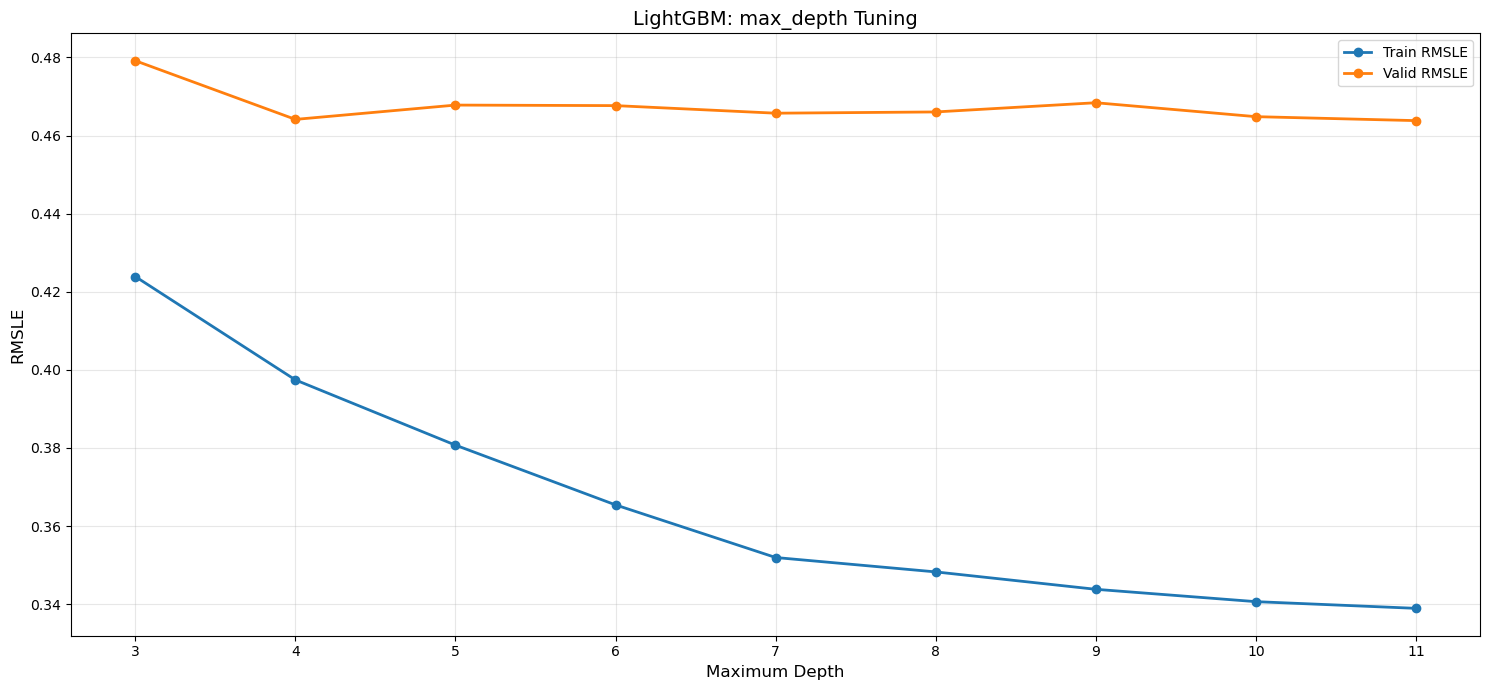

In [10]:
# Tune max_depth


def get_max_depth_lgb(evaluation_set, optimal_n_estimators=800, optimal_num_leaves=80, optimal_min_samples=20):
    results = []
    
    for depth in range(3, 12):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
             train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']
   
            model = lgb.LGBMRegressor(
                n_estimators=optimal_n_estimators,
                learning_rate=0.01,
                num_leaves=optimal_num_leaves,
                max_depth=depth,
                min_child_samples=optimal_min_samples,
                random_state=0,
                n_jobs=4,
                verbosity=-1
            )
  
            model.fit(train_data_x, train_data_y)
     
            train_pred = model.predict(train_data_x)
            valid_pred = model.predict(valid_data_x)
  
            SCORE_TRAIN.append(get_msle(train_data_y, train_pred))
            SCORE_VALID.append(get_msle(valid_data_y, valid_pred))

        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'max_depth: {depth:2d} | Train RMSLE: {mean_score_train:.4f} | Valid RMSLE: {mean_score_valid:.4f}')
        
        x['max_depth'] = depth
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame.from_dict(results)

# max_depth tuning
max_depth_result = get_max_depth_lgb(evaluation_set, optimal_n_estimators=800, optimal_num_leaves=80, optimal_min_samples=20)

# Plot max_depth results
plt.figure(figsize=(15, 7))
plt.plot(max_depth_result['max_depth'], max_depth_result['mean_rmsle_train'], 
         label='Train RMSLE', marker='o', linewidth=2)
plt.plot(max_depth_result['max_depth'], max_depth_result['mean_rmsle_valid'], 
         label='Valid RMSLE', marker='o', linewidth=2)
plt.xlabel('Maximum Depth', fontsize=12)
plt.ylabel('RMSLE', fontsize=12)
plt.title('LightGBM: max_depth Tuning', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

           


Best validation RMSLE is seen at max_depth =4 slthough train RMSLE continues to drop substantially until max_depth =7

min_split_gain:  0.00 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
min_split_gain:  0.01 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4668
min_split_gain:  0.10 | Train RMSLE: 0.3658 | Valid RMSLE: 0.4673
min_split_gain:  0.50 | Train RMSLE: 0.3656 | Valid RMSLE: 0.4671
min_split_gain:  1.00 | Train RMSLE: 0.3656 | Valid RMSLE: 0.4644
min_split_gain: 10.00 | Train RMSLE: 0.3656 | Valid RMSLE: 0.4656
min_split_gain: 100.00 | Train RMSLE: 0.3675 | Valid RMSLE: 0.4634


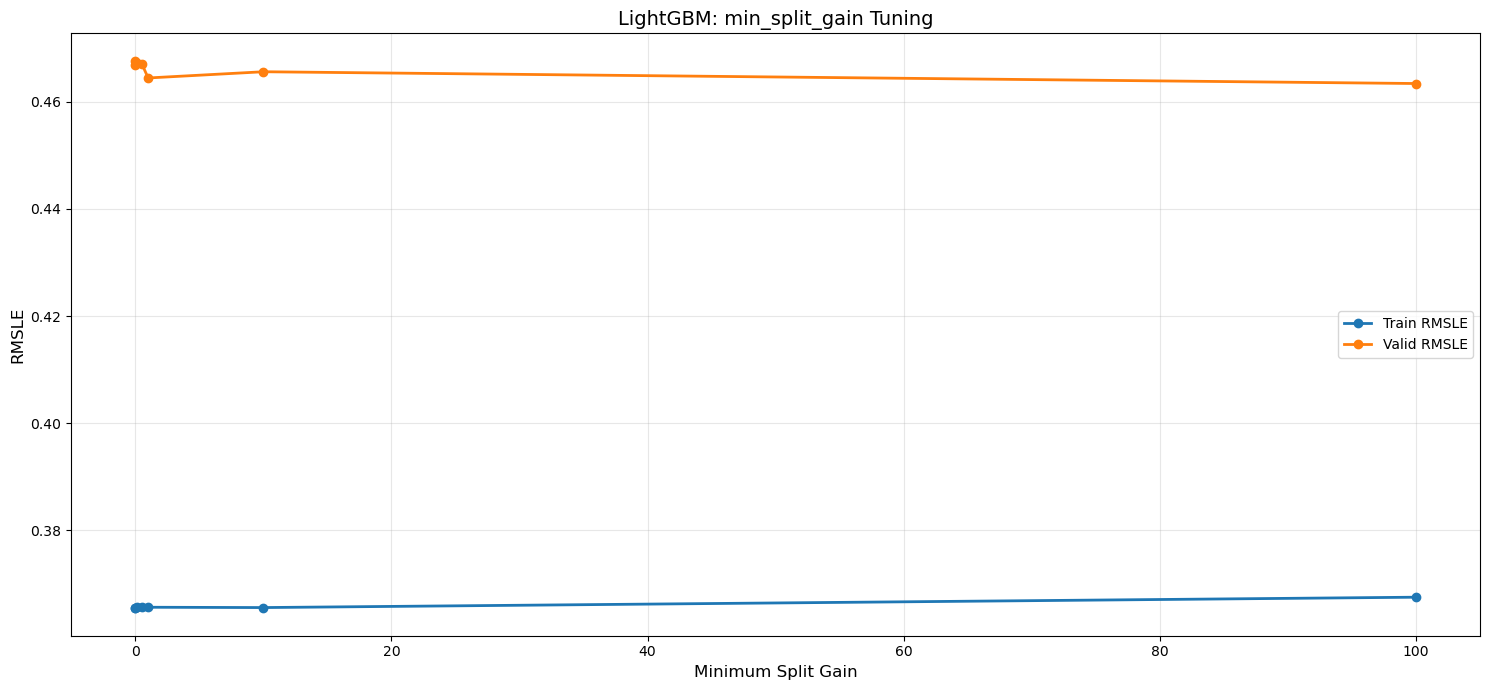

In [11]:
# Tune min_gain_to_split 

def get_min_split_gain(evaluation_set, optimal_n_estimators=800, optimal_num_leaves=80, 
                       optimal_min_samples=20, optimal_depth=6):
    results = []
    
    for min_gain in [0, 0.01, 0.1, 0.5, 1, 10, 100]:
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
            train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            model = lgb.LGBMRegressor(
                n_estimators=optimal_n_estimators,
                learning_rate=0.01,
                num_leaves=optimal_num_leaves,
                max_depth=optimal_depth,
                min_child_samples=optimal_min_samples,
                min_split_gain=min_gain,
                random_state=0,
                n_jobs=4,
                verbosity=-1
            )

            model.fit(train_data_x, train_data_y)

            train_pred = model.predict(train_data_x)
            valid_pred = model.predict(valid_data_x)

            SCORE_TRAIN.append(get_msle(train_data_y, train_pred))
            SCORE_VALID.append(get_msle(valid_data_y, valid_pred))

        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'min_split_gain: {min_gain:5.2f} | Train RMSLE: {mean_score_train:.4f} | Valid RMSLE: {mean_score_valid:.4f}')
        
        x['min_split_gain'] = min_gain
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame.from_dict(results)

# min_split_gain tuning
min_gain_result = get_min_split_gain(evaluation_set, optimal_n_estimators=800, optimal_num_leaves=80, 
                                     optimal_min_samples=20, optimal_depth=6)

# Plot min_split_gain results
plt.figure(figsize=(15, 7))
plt.plot(min_gain_result['min_split_gain'], min_gain_result['mean_rmsle_train'], 
         label='Train RMSLE', marker='o', linewidth=2)
plt.plot(min_gain_result['min_split_gain'], min_gain_result['mean_rmsle_valid'], 
         label='Valid RMSLE', marker='o', linewidth=2)
plt.xlabel('Minimum Split Gain', fontsize=12)
plt.ylabel('RMSLE', fontsize=12)
plt.title('LightGBM: min_split_gain Tuning', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


There is hardly any gain and hence one can be more conservative and take min_split_gain at even 0 or 1 instead of 100

subsample:  0.010 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.050 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.075 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.100 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.400 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.600 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.700 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.800 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.900 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.950 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.970 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.990 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  0.999 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677
subsample:  1.000 | Train RMSLE: 0.3654 | Valid RMSLE: 0.4677


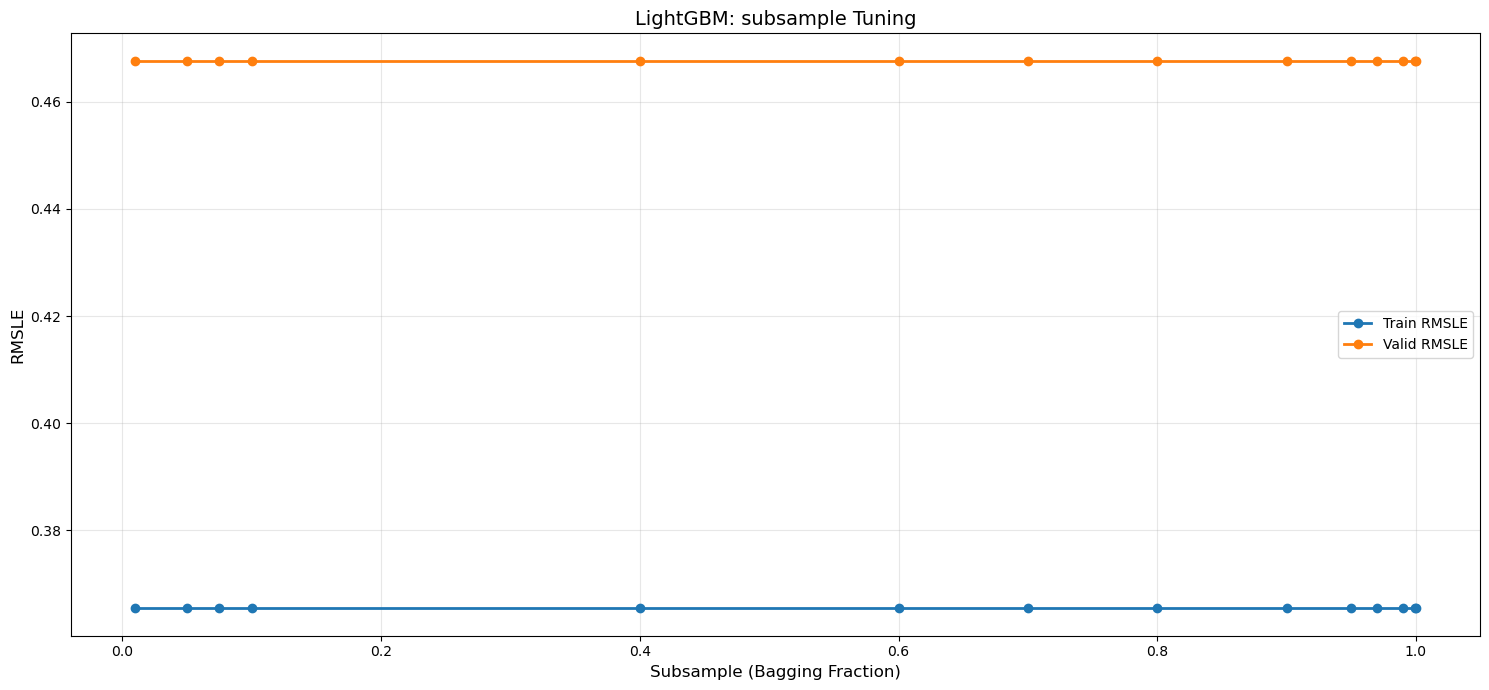

In [12]:

# Tune bagging_fraction and feature_fraction


def get_subsample_lgb(evaluation_set, optimal_n_estimators=800, optimal_num_leaves=80, 
                      optimal_min_samples=20, optimal_depth=6, optimal_min_gain=0):
    results = []
    
    for subsample in [0.01, 0.05, 0.075, 0.1, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 0.999, 1]:
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
            train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']
  
            model = lgb.LGBMRegressor(
                n_estimators=optimal_n_estimators,
                learning_rate=0.01,
                num_leaves=optimal_num_leaves,
                max_depth=optimal_depth,
                min_child_samples=optimal_min_samples,
                min_split_gain=optimal_min_gain,
                subsample=subsample,
                random_state=0,
                n_jobs=4,
                verbosity=-1
            )

            model.fit(train_data_x, train_data_y)

            train_pred = model.predict(train_data_x)
            valid_pred = model.predict(valid_data_x)
 
            SCORE_TRAIN.append(get_msle(train_data_y, train_pred))
            SCORE_VALID.append(get_msle(valid_data_y, valid_pred))
        

        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'subsample: {subsample:6.3f} | Train RMSLE: {mean_score_train:.4f} | Valid RMSLE: {mean_score_valid:.4f}')
        
        x['subsample'] = subsample
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame.from_dict(results)

# Run subsample tuning
subsample_result = get_subsample_lgb(evaluation_set, optimal_n_estimators=800, optimal_num_leaves=80, 
                                     optimal_min_samples=20, optimal_depth=6, optimal_min_gain=0)

# Plot subsample results
plt.figure(figsize=(15, 7))
plt.plot(subsample_result['subsample'], subsample_result['mean_rmsle_train'], 
         label='Train RMSLE', marker='o', linewidth=2)
plt.plot(subsample_result['subsample'], subsample_result['mean_rmsle_valid'], 
         label='Valid RMSLE', marker='o', linewidth=2)
plt.xlabel('Subsample (Bagging Fraction)', fontsize=12)
plt.ylabel('RMSLE', fontsize=12)
plt.title('LightGBM: subsample Tuning', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

  



Based on the above plots and also the min RMSLE socre achieved during the tunings, the following parameters are taken as the final set for LightGBM 

In [13]:
final_lightgbm_params = {
    # Core parameters
    'n_estimators': 800,
    'learning_rate': 0.01,
    
    # Tree parameters
    'num_leaves': 80,
    'max_depth': 4,
    'min_child_samples': 5,
    'min_split_gain': 0,
    
    # Subsampling
    'subsample': 0.8,
    'feature_fraction': 0.8,  
    
    # Regularization
    'reg_alpha': 0.0,  
    'reg_lambda': 0.0,  
    
 
    'random_state': 0,
    'n_jobs': 4,
    'verbosity': -1
}



In [14]:
def train_final_lightgbm(evaluation_set, params=final_lightgbm_params):
    final_scores = []
    
    for idx, (train, valid) in enumerate(evaluation_set):

        train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
        train_data_y = train['UNITS']
        valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
        valid_data_y = valid['UNITS']
        

        model = lgb.LGBMRegressor(**params)
        

        model.fit(train_data_x, train_data_y)
        

        train_pred = model.predict(train_data_x)
        valid_pred = model.predict(valid_data_x)

        train_rmsle = get_msle(train_data_y, train_pred)
        valid_rmsle = get_msle(valid_data_y, valid_pred)
        
        final_scores.append({
            'train_rmsle': train_rmsle,
            'valid_rmsle': valid_rmsle
        })
        
        print(f"Set {idx+1}: Train RMSLE = {train_rmsle:.4f}, Valid RMSLE = {valid_rmsle:.4f}")

    avg_train = np.mean([s['train_rmsle'] for s in final_scores])
    avg_valid = np.mean([s['valid_rmsle'] for s in final_scores])
    
    print(f"\nAverage Train RMSLE: {avg_train:.4f}")
    print(f"Average Valid RMSLE: {avg_valid:.4f}")
    
    return avg_train, avg_valid

print("\nTraining final LightGBM model with optimized parameters...")
final_train_score, final_valid_score = train_final_lightgbm(evaluation_set)


Training final LightGBM model with optimized parameters...
Set 1: Train RMSLE = 0.4039, Valid RMSLE = 0.4083
Set 2: Train RMSLE = 0.3985, Valid RMSLE = 0.4716
Set 3: Train RMSLE = 0.3964, Valid RMSLE = 0.5330
Set 4: Train RMSLE = 0.4007, Valid RMSLE = 0.4751
Set 5: Train RMSLE = 0.3877, Valid RMSLE = 0.4413
Set 6: Train RMSLE = 0.3836, Valid RMSLE = 0.5359
Set 7: Train RMSLE = 0.3801, Valid RMSLE = 0.4129
Set 8: Train RMSLE = 0.3808, Valid RMSLE = 0.4620
Set 9: Train RMSLE = 0.3914, Valid RMSLE = 0.4370
Set 10: Train RMSLE = 0.4007, Valid RMSLE = 0.4527
Set 11: Train RMSLE = 0.3980, Valid RMSLE = 0.4561
Set 12: Train RMSLE = 0.3959, Valid RMSLE = 0.4482
Set 13: Train RMSLE = 0.4034, Valid RMSLE = 0.4477
Set 14: Train RMSLE = 0.4037, Valid RMSLE = 0.5084

Average Train RMSLE: 0.3946
Average Valid RMSLE: 0.4636
